In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Concatenate, BatchNormalization, Dropout, MultiHeadAttention, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import shutil

2025-08-09 10:22:25.243563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754734945.451070      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754734945.509849      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define dataset paths (already split into folders)
base_dir = "/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256"
train_dir = os.path.join(base_dir, "Training")
valid_dir = os.path.join(base_dir, "Validation")
test_dir = os.path.join(base_dir, "Testing")

print("Train Directory:", train_dir)
print("Validation Directory:", valid_dir)
print("Test Directory:", test_dir)

Train Directory: /kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Training
Validation Directory: /kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Validation
Test Directory: /kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Testing


In [4]:


# Step 1: Data Augmentation & Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For validation and test, we only rescale
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = test_val_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for evaluation consistency
)


Found 3251 images belonging to 3 classes.
Found 416 images belonging to 3 classes.
Found 405 images belonging to 3 classes.


In [5]:
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization,
    LayerNormalization, MultiHeadAttention, Reshape, Concatenate, Add, Activation
)
from tensorflow.keras.optimizers import Adam

def build_hybrid_model(num_classes, input_shape=(224, 224, 3)):
    # Pretrained base models
    base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

    base_resnet.trainable = True
    base_densenet.trainable = True

    # Input
    input_layer = Input(shape=input_shape)

    # Feature extraction
    resnet_features = base_resnet(input_layer)
    densenet_features = base_densenet(input_layer)

    # Global pooling
    resnet_features = GlobalAveragePooling2D()(resnet_features)
    densenet_features = GlobalAveragePooling2D()(densenet_features)

    # Dense mapping
    resnet_features = Dense(1024, activation="relu")(resnet_features)
    densenet_features = Dense(1024, activation="relu")(densenet_features)

    # Attention mechanism
    resnet_reshaped = Reshape((1, 1024))(resnet_features)
    densenet_reshaped = Reshape((1, 1024))(densenet_features)

    attention_layer = MultiHeadAttention(num_heads=4, key_dim=256)
    attention_output = attention_layer(resnet_reshaped, densenet_reshaped)
    attention_output = LayerNormalization()(attention_output)
    attention_output = Reshape((1024,))(attention_output)

    # FIX: Merge everything via Concatenate (safe)
    fused = Concatenate()([resnet_features, densenet_features, attention_output])  # (3072,)
    x = Activation('relu')(fused)

    # Fully connected layers
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)

    # Output
    output = Dense(num_classes, activation='softmax')(x)

    # Compile model
    model = Model(inputs=input_layer, outputs=output)
    optimizer = Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model




   
   
    

In [6]:
# Pull number of classes from the train generator
num_classes = train_generator.num_classes

# Build and summarize model
model_hybrid = build_hybrid_model(num_classes=num_classes)
model_hybrid.summary()

I0000 00:00:1754734959.122988      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754734959.123692      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ densenet121 (Functional)  │ (None, 7, 7, 1024)     │      7,037,504 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1024)           │              0 │ densenet121[0][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1024)           │      2,098,176 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1024)           │      1,049,600 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1024)        │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 1024)        │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 1, 1024)        │      4,198,400 │ reshape[0][0],         │
│ (MultiHeadAttention)      │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 1, 1024)        │          2,048 │ multi_head_attention[… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 1024)           │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 3072)           │              0 │ dense[0][0],           │
│                           │                        │                │ dense_1[0][0],         │
│                           │                        │                │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 3072)           │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 3072)           │         12,288 │ activation[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)  

 Total params: 39,691,203 (151.41 MB)

 Trainable params: 39,548,291 (150.86 MB)

 Non-trainable params: 142,912 (558.25 KB)

In [7]:
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Fit the model
history = model_hybrid.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=25,
    callbacks=[lr_scheduler]
)


Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1754735108.545425     112 service.cc:148] XLA service 0x7b314c0025a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754735108.546290     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:17547351

102/102 ━━━━━━━━━━━━━━━━━━━━ 472s 2s/step - accuracy: 0.7578 - loss: 0.6283 - val_accuracy: 0.8197 - val_loss: 0.5185 - learning_rate: 1.0000e-04
Epoch 2/25
102/102 ━━━━━━━━━━━━━━━━━━━━ 72s 680ms/step - accuracy: 0.9600 - loss: 0.1394 - val_accuracy: 0.9159 - val_loss: 0.2882 - learning_rate: 1.0000e-04
Epoch 3/25
102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 668ms/step - accuracy: 0.9605 - loss: 0.1231 - val_accuracy: 0.6779 - val_loss: 1.1546 - learning_rate: 1.0000e-04
Epoch 4/25
102/102 ━━━━━━━━━━━━━━━━━━━━ 70s 660ms/step - accuracy: 0.9643 - loss: 0.1164 - val_accuracy: 0.8005 - val_loss: 0.5946 - learning_rate: 1.0000e-04
Epoch 5/25
102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 668ms/step - accuracy: 0.9752 - loss: 0.0797 - val_accuracy: 0.9591 - val_loss: 0.1213 - learning_rate: 1.0000e-04
Epoch 6/25
102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 668ms/step - accuracy: 0.9722 - loss: 0.0780 - val_accuracy: 0.9663 - val_loss: 0.0887 - learning_rate: 1.0000e-04
Epoch 7/25
102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 667ms/step - ac

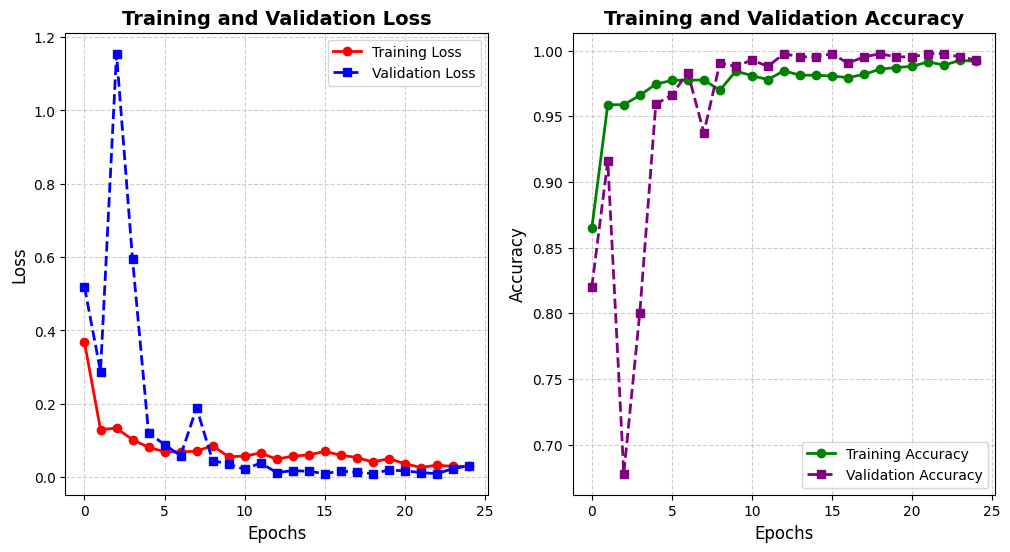

In [8]:
# Step 5: Training Loss and Accuracy Visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], marker='o', linestyle='-', color='red', linewidth=2, label='Training Loss')
plt.plot(history.history['val_loss'], marker='s', linestyle='--', color='blue', linewidth=2, label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], marker='o', linestyle='-', color='green', linewidth=2, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], marker='s', linestyle='--', color='purple', linewidth=2, label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [9]:

# Step 4: Evaluate Model
test_loss, test_accuracy = model_hybrid.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9946 - loss: 0.0248 
Test Accuracy: 99.26%


In [10]:
import numpy as np
from sklearn.metrics import classification_report

# Step 5: Compute Metrics
y_pred = model_hybrid.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_test_classes = test_generator.classes

# Class label names (in correct order)
class_indices = test_generator.class_indices
class_labels = list(class_indices.keys())

# Print classification report
print(classification_report(y_test_classes, y_pred_classes, target_names=class_labels))


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step 
              precision    recall  f1-score   support

Early_Blight       0.99      0.99      0.99       162
     Healthy       0.98      1.00      0.99       102
 Late_Blight       1.00      0.99      0.99       141

    accuracy                           0.99       405
   macro avg       0.99      0.99      0.99       405
weighted avg       0.99      0.99      0.99       405



In [12]:
import numpy as np
from sklearn.metrics import classification_report

# Step 5: Compute Metrics
y_pred = model_hybrid.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_test_classes = test_generator.classes

# Class label names (in correct order)
class_indices = test_generator.class_indices
class_labels = list(class_indices.keys())

# Get classification report as dictionary
report = classification_report(
    y_test_classes, 
    y_pred_classes, 
    target_names=class_labels, 
    output_dict=True
)

# Calculate average metrics (macro average ignores class imbalance)
avg_precision = report['macro avg']['precision']
avg_recall = report['macro avg']['recall']
avg_f1 = report['macro avg']['f1-score']
accuracy = report['accuracy']  # sklearn already gives overall accuracy

print(f"Average Accuracy: {accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step
Average Accuracy: 0.9926
Average Precision: 0.9915
Average Recall: 0.9932
Average F1 Score: 0.9923


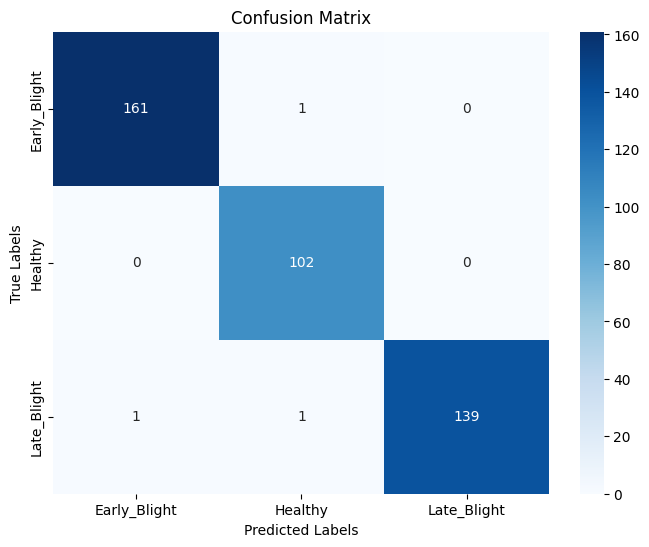

In [11]:
# Step 7: Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
